### Estimating the part of NIWs kinetic energy locally dissipated
A decorrelation timescale, $\varepsilon_t$, is defined as the time it takes for a mean value of near inertial kinetic energy (NI KE) to dissipate at dmean dissipation rate, $\varepsilon$. The reference for this work is found in Kunze et al, 2023.
\begin{align}
\varepsilon_t = \overline{NI\:KE}/\overline{\varepsilon}
\end{align}
where $\overline{.}$ represents an average over time and depth. Here, the depth range is fixed at [400m;900m]. The time period used in average, $\Delta t$, is defined for each NIWs event.

$\Delta t$ for each event is defined using a threshold of $7.10^{-4}$ $m^2s^{-2}$ and visual validation. The number of events and high NI KE patterns that cannot be directly linked to dwnward propagation from the mixed layer makes it impossible to set rigorous criteria appropriate for every event. Due to this, we consider the error on $\Delta t$ is of 2 days.

In [76]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime,timedelta
import pandas as pd

import niskine
import mplniw.plot as pl
import gvpy as gv
import mplniw.sigp as sp
import mplniw.utils as ut
import matplotlib.ticker as tkr
import matplotlib.lines as mlines


import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

In [77]:
import cartopy.crs as ccrs
import cmocean
import matplotlib.path as mpath
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER,LatitudeLocator, LongitudeLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy
import matplotlib.ticker as mticker

In [3]:
mooring=1
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=mooring)
root_dir = '/Users/zcasparcohen/codes/NIW/'
figdir = '/Users/zcasparcohen/Documents/Figures_paper/'

In [68]:
#Moorings coordinates and seafloor depth
m1lon, m1lat, m1bottom_depth = niskine.io.mooring_location(mooring=1)
m2lon, m2lat, m2bottom_depth = niskine.io.mooring_location(mooring=2)
m3lon, m3lat, m3bottom_depth = niskine.io.mooring_location(mooring=3)

In [5]:
# Wind
wind_work = xr.open_dataset(root_dir+'data/ni_wind_work_niskine_m1.nc').rename({'__xarray_dataarray_variable__':'wind_work'})
wind_stress = xr.open_dataarray(root_dir+'data/wind_work/wind_stress_niskine_m1.nc')
wind_clim=xr.open_dataset( '/Users/zcasparcohen/codes/MOTIVE/copernicus-wind/cmems_obs-wind_glo_phy_my_l4_P1M.nc')

#Velocity time series
ds = xr.open_dataset(root_dir+'data/NI02_M%s.nc'%mooring)
gridded=xr.open_dataset(root_dir+'data/M%s_linear_merge_slinearfill.nc'%mooring)[['u','v']]
wkb = niskine.clim.get_wkb_factors(gridded)
ds['bpuz'] = wkb*ds['u_filtered'].differentiate('z')
ds['bpvz'] = wkb*ds['v_filtered'].differentiate('z')

ds['uz'] = wkb*ds['u'].differentiate('z')
ds['vz'] = wkb*ds['v'].differentiate('z')

#Vorticity
vort = xr.open_dataset(root_dir+'data/vorticity_moorings.nc')
vort_alt = xr.open_dataset(root_dir+'data/vorticity_alt.nc')

#N
N2 = xr.open_dataset(root_dir+'data/N_daily.nc').rename({'__xarray_dataarray_variable__':'N2'})

#Low frequency motion from moorings
ds_low = xr.open_dataset(root_dir+'data/M%s_lpfiltered.nc'%mooring).interpolate_na(dim='time',method='cubic',max_gap=pd.Timedelta(3, "d"))

#Satellite-derived mesoscale velocity and energy 
alt = niskine.io.load_ssh()
alt['eke'] = 1/2 * (alt.ugosa**2 + alt.vgosa**2)
from datetime import datetime
eke = alt.eke.sel(time=slice('2019-06-01','2020-10-01'))#.plot()
_time = eke.time

In [6]:
#Mean mesoscale flow
alt['ugos_mean'] = alt.ugos.mean('time')
alt['vgos_mean'] = alt.vgos.mean('time')

In [7]:
#Center of the moorings
d = 2 * (m1lon * (m2lat - m3lat) + m2lon * (m3lat - m1lat) + m3lon * (m1lat - m2lat))
midlon = ((m1lon * m1lon + m1lat * m1lat) * (m2lat - m3lat) + (m2lon * m2lon + m2lat * m2lat) * (m3lat - m1lat) + (m3lon * m3lon + m3lat * m3lat) * (m1lat - m2lat)) / d
midlat = ((m1lon * m1lon + m1lat * m1lat) * (m3lon - m2lon) + (m2lon * m2lon + m2lat * m2lat) * (m1lon - m3lon) + (m3lon * m3lon + m3lat * m3lat) * (m2lon - m1lon)) / d

In [8]:
#Stratififcation at mooring M1
N2 = xr.open_dataarray(root_dir+'data/N_daily.nc')

In [9]:
#Dissipation rate computed at mooring M1
eps = xr.open_dataset(root_dir+'data/eps.nc')
eps_small = xr.open_dataset(root_dir+'data/eps_small.nc')

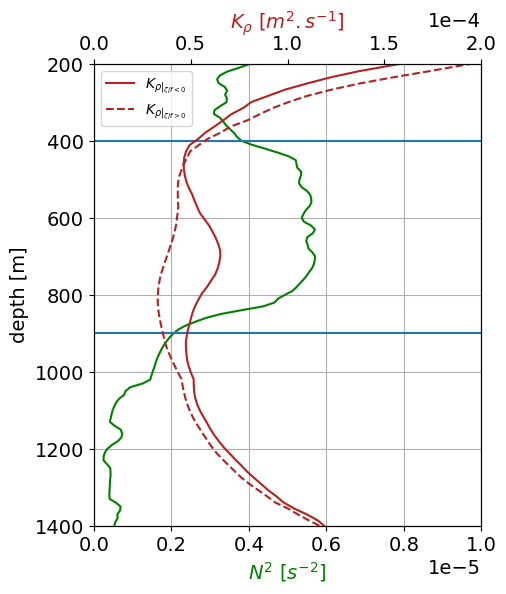

In [71]:
#Visualizing mean stratification and diffusivity at mooring M1

fig,ax=plt.subplots(figsize=(5,6))
N2.mean('time').plot(ax=ax,y='depth',yincrease=False,c='g',xlim=(0,1e-5))
ax1=ax.twiny()
eps.krho.where(vort.vorticity_norm.mean('z')<0).mean('time').plot(ax=ax1,y='depth_bin',yincrease=False,c='firebrick',xlim=(0,None),
                                                                  label=r'$K_{\rho\vert_{\zeta/f<0}}$')
eps.krho.where(vort.vorticity_norm.mean('z')>0).mean('time').plot(ax=ax1,y='depth_bin',yincrease=False,c='firebrick',xlim=(0,2e-4),ls='--',
                                                                 label=r'$K_{\rho\vert_{\zeta/f>0}}$')
ax1.set_xlabel(r'$K_\rho$ [$m^2.s^{-1}$]',c='firebrick')
ax.set_xlabel(r'$N^2$ [$s^{-2}$]',c='g')
ax1.ticklabel_format(axis='x',style='sci',scilimits=(-3,0))
ax1.legend();ax.axhline(400);ax.axhline(900)
ax.set_ylim(1400,200)
ax.grid()

In [13]:
#Mean dissipation rate and NI KE in the pycnocline (400m to 900m)
eps_t = eps.eps.sel(depth_bin=slice(400,900)).mean('depth_bin')
nike_t=ds.ni_ke.sel(z=slice(400,900)).mean('z').rolling(time=150).mean().shift(time=-75)

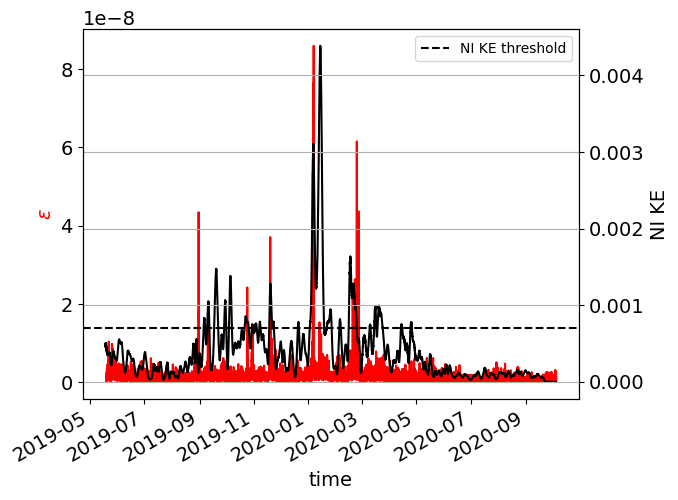

In [96]:
# Visualization of depth-averaged NI KE and definition of a threhold to define NIWs events
fig,ax=plt.subplots()
eps_t.plot(ax=ax,zorder=-1,c='r');ax.set_ylabel(r'$\varepsilon$',c='r')
ax1=ax.twinx()
nike_t.plot(ax=ax1,c='k',zorder=1);ax1.set_ylabel('NI KE',c='k')
ax1.axhline(0.0007,c='k',ls='--',label='NI KE threshold');ax1.grid();
ax1.legend()

In [15]:
print('Dissipation time scale, 18 months: ', np.around(((nike_t/eps_t).where(nike_t>0.0005)/3600/24).mean().values,decimals=1),'days')
print('Dissipation time scale, 11/11-22/11: ',
      np.around(((nike_t/eps_t).where(nike_t>0.0005)/3600/24).sel(time=slice('11-11-2019','24-11-2019')).mean().values,decimals=1),
     'days')

print('Dissipation time scale, 11/11-24/11: ',
      np.around(((nike_t/eps_t)/3600/24).sel(time=slice('11-11-2019','24-11-2019')).mean().values,decimals=1),
     'days')

Dissipation time scale, 18 months:  9.0 days
Dissipation time scale, 11/11-22/11:  5.4 days
Dissipation time scale, 11/11-24/11:  5.3 days


In [75]:
print('Mean absolute vorticity in summer:',np.abs(xr.merge([vort.vorticity_norm.sel(time=slice('06-2019','08-2019')),
                                                            vort.vorticity_norm.sel(time=slice('06-2020','08-2020'))])
                                                 ).vorticity_norm.mean().values)
print('Mean absolute vorticity except summer:',np.abs(vort.vorticity_norm.sel(time=slice('09-2019','05-2020'))).mean().values)

Mean absolute vorticity in summer: 0.0813516966560165
Mean absolute vorticity except summer: 0.06396257509931925


#### Example of estimation of $\Delta t$ for one event

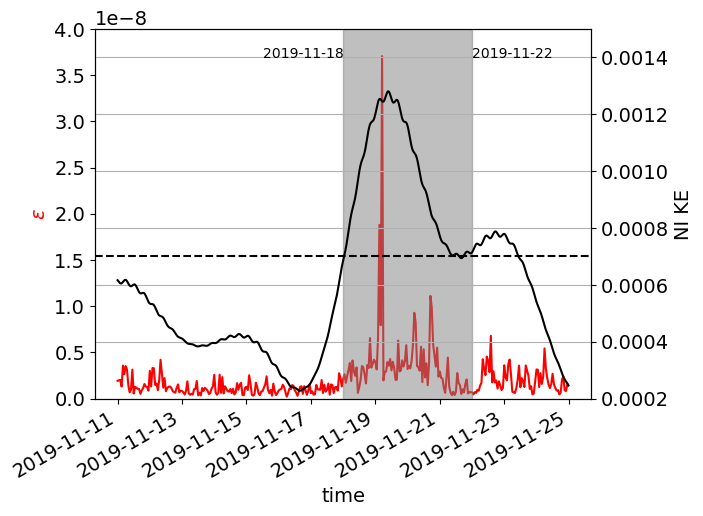

In [139]:
#First estimation using mean NI KE and dissipation rate
t0,t1 = '11-11-2019','24-11-2019' #time range to plot
daterange=pd.date_range('18-11-2019',periods=5.5) #Delta t date range
fig,ax=plt.subplots()
eps_t.sel(time=slice(t0,t1)).plot(ax=ax,c='r')
ax.set_ylabel(r'$\epsilon$',c='r');ax.set_ylim(0,4e-8)
ax1=ax.twinx()
nike_t.sel(time=slice(t0,t1)).plot(ax=ax1,c='k')
ax1.fill_betweenx((0,0.0015),daterange[0],daterange[-1],color='grey',alpha=0.5)
ax1.axhline(0.0007,c='k',ls='--');ax1.set_ylim(2e-4,1.5e-3)
ax1.set_ylabel(r'NI KE',c='k');
ax1.text(daterange[0]-pd.Timedelta('60H'),0.0014,daterange[0].date())
ax1.text(daterange[-1],0.0014,daterange[-1].date())
ax1.grid()

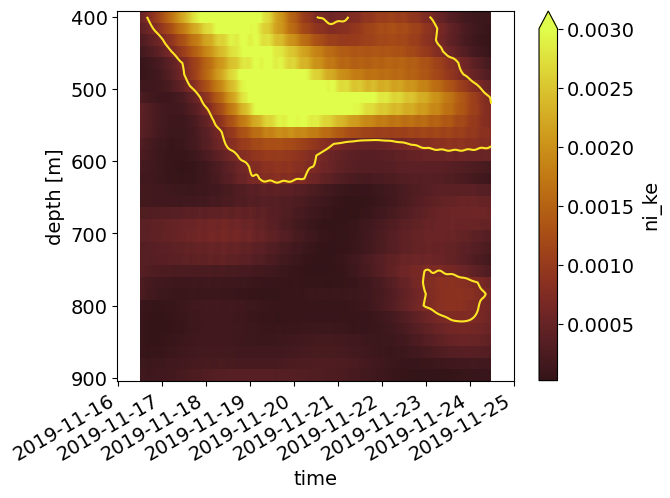

In [144]:
#Validating Delta t estimations with 2D NI KE
plt.figure()
daterange=pd.date_range('16-11-2019',periods=10) #Delta t date range
ds.ni_ke.sel(time=slice(daterange[0],daterange[-1]),z=slice(400,900)
            ).rolling(time=150).mean().shift(time=-75).plot(yincrease=False,cmap=cmocean.cm.solar,vmax=3e-3)
ds.ni_ke.sel(time=slice(daterange[0],daterange[-1]),z=slice(400,900)
            ).rolling(time=150).mean().shift(time=-75).plot.contour(yincrease=False,levels=[7e-4])

In [148]:
#Definition of first day of each event and duration of event in pycnocline
events_t0=['2019-09-05','2019-09-09','2019-09-17','2019-10-20','2019-11-02','2019-11-06','2019-11-17','2020-01-01','2020-02-15',
           '2020-03-18','2020-04-13']
#'2020-03-13': removed, the high NI KE was in the MLD, which happened to in the mean pycnocline depth range.
events_dt=[3,4,6,7,9,8,7,20,10,8,3.5]
#4.5: removed, the high NI KE was in the MLD, which happened to in the mean pycnocline depth range.

In [147]:
#Selecting dissipation timescale and NI KE during Delta t and computing dissipation timescale 
dissipation_t=[] #dissipation timescale
nt,et=[],[] #
for i in range(len(events_dt)):
    daterange=pd.date_range(events_t0[i],periods=events_dt[i])
    nt.append(nike_t.sel(time=slice(daterange[0],daterange[-1])))
    et.append(eps_t.sel(time=slice(daterange[0],daterange[-1])))
    dissipation_t.append((nt[i]/et[i]/3600/24).mean().values)
             

In [64]:
#Vorticity and MLD during event
vorticity_dt = []
mld_dt = []
for i in range(len(events_t0)):
    daterange=pd.date_range(events_t0[i],periods=events_dt[i])
    vorticity_dt.append(np.abs(vort.vorticity_norm.sel(time=daterange,z=slice(400,900))).mean().values)
    mld_dt.append(ds.mld.sel(time=daterange).mean().values)

In [149]:
#Colors to use when plotting different colors for each event
cmap = mpl.colormaps.get_cmap('Greys')
# Pick N numbers from 0 to 1
gradient = np.linspace(0.3, 1, len(events_t0))
colors = [mpl.colors.to_rgb(cmap(i)) for i in gradient]

(3.0, 15.0)

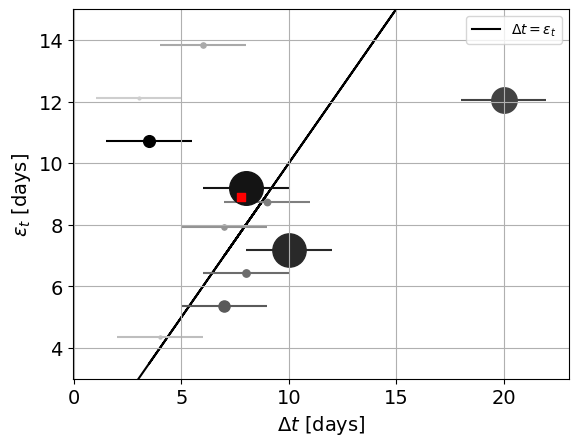

In [152]:
for i,c in zip(range(len(events_t0)),colors):
    plt.errorbar(events_dt[i],dissipation_t[i],xerr=2,fmt='o',c=c,markersize=mld_dt[i]/20,zorder=0)
    #,c=colors[i],ecolor=colors[i]
#plt.scatter(events_dt,dissipation_t)
plt.plot(events_dt,events_dt,c='k',label=r'$\Delta t = \epsilon_t$',zorder=-1)
plt.scatter(np.mean(events_dt),np.mean(dissipation_t),c='r',marker='s',zorder=1)
plt.legend();plt.ylabel(r'$\epsilon_t$ [days]');plt.xlabel(r'$\Delta t$ [days]')
plt.grid();plt.ylim(3,15)

(3.0, 15.0)

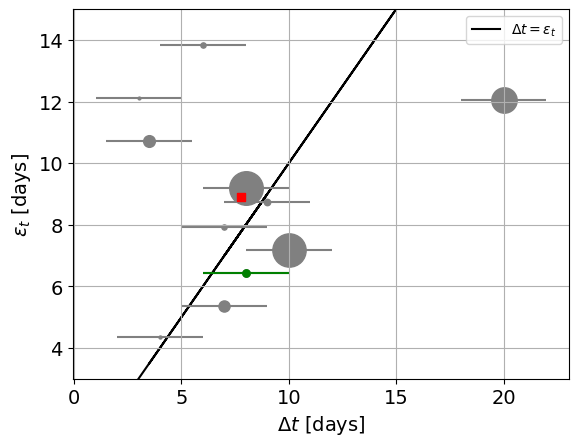

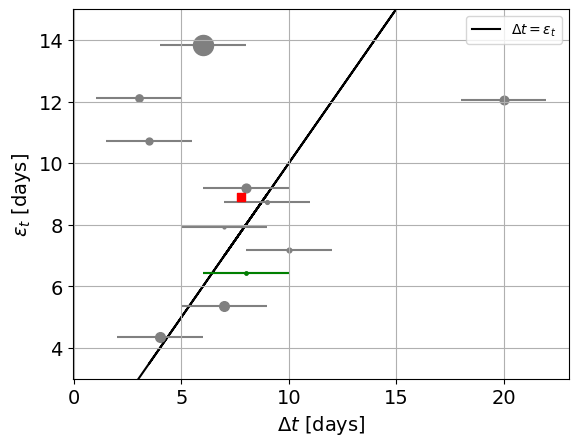

In [156]:
#Size of circles correspond to MLD
for i in range(len(events_t0)):
    plt.errorbar(events_dt[i],dissipation_t[i],xerr=2,fmt='o',c='grey',markersize=mld_dt[i]/20,zorder=0)
    #,c=colors[i],ecolor=colors[i]
#plt.scatter(events_dt,dissipation_t)
plt.plot(events_dt,events_dt,c='k',label=r'$\Delta t = \epsilon_t$',zorder=-1)
plt.scatter(np.mean(events_dt),np.mean(dissipation_t),c='r',marker='s',zorder=1)
plt.errorbar(events_dt[5],dissipation_t[5],xerr=2,fmt='o',c='green',markersize=mld_dt[5]/20,zorder=1)
plt.legend();plt.ylabel(r'$\epsilon_t$ [days]');plt.xlabel(r'$\Delta t$ [days]')
plt.grid();plt.ylim(3,15)
plt.savefig(figdir+'dt_epst.png')

plt.figure()
#Size of circles correspond to absolute vorticity
for i in range(len(events_t0)):
    plt.errorbar(events_dt[i],dissipation_t[i],xerr=2,fmt='o',c='grey',markersize=vorticity_dt[i]*100,zorder=0)
    #,c=colors[i],ecolor=colors[i]
#plt.scatter(events_dt,dissipation_t)
plt.plot(events_dt,events_dt,c='k',label=r'$\Delta t = \epsilon_t$',zorder=-1)
plt.scatter(np.mean(events_dt),np.mean(dissipation_t),c='r',marker='s',zorder=1)
plt.errorbar(events_dt[5],dissipation_t[5],xerr=2,fmt='o',c='green',markersize=vorticity_dt[5]*100,zorder=1)
plt.legend();plt.ylabel(r'$\epsilon_t$ [days]');plt.xlabel(r'$\Delta t$ [days]')
plt.grid();plt.ylim(3,15)
#plt.savefig(figdir+'dt_epst.png')